# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils
import ameritrade_functions as amc

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-12-16 10:29:09,681|IRAHoldingsAdjustement|INFO|Python version: 3.8.15
2022-12-16 10:29:09,681|IRAHoldingsAdjustement|INFO|Pandas version: 1.5.2


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-12-16 10:29:09,700|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-12-16 10:29:10,812|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-12-11 00:00:00|2022-12-09 00:00:00
2022-12-16 10:29:10,842|IRAHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-12-16 10:29:10,843|IRAHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-12-16 10:29:11,052|IRAHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-12-16 10:29:11,069|IRAHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.08
2022-12-16 10:29:11,069|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.15
2022-12-16 10:29:11,070|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-12-16 10:32:39,311|IRAHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.87|501->438


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-12-16 10:32:39,339|IRAHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|438
2022-12-16 10:32:39,409|IRAHoldingsAdjustement|INFO|OPT_DATE|2022-12-09 00:00:00


2022-12-16 10:32:54,846|IRAHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01624917


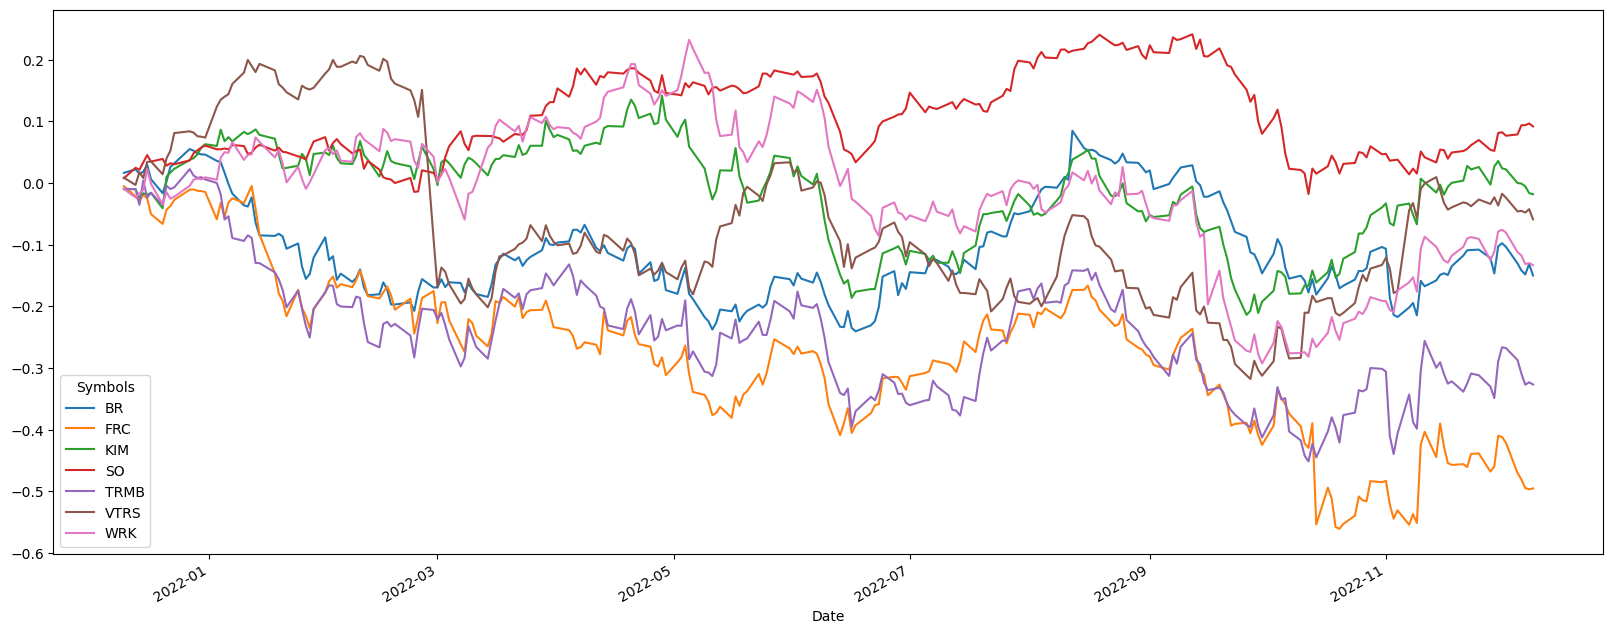

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-12-16 10:32:55,327|IRAHoldingsAdjustement|INFO|STOCK|BR                  |HOLDING|0.150000
2022-12-16 10:32:55,328|IRAHoldingsAdjustement|INFO|STOCK|FRC                 |HOLDING|0.150000
2022-12-16 10:32:55,329|IRAHoldingsAdjustement|INFO|STOCK|KIM                 |HOLDING|0.150000
2022-12-16 10:32:55,330|IRAHoldingsAdjustement|INFO|STOCK|SO                  |HOLDING|0.150000
2022-12-16 10:32:55,330|IRAHoldingsAdjustement|INFO|STOCK|TRMB                |HOLDING|0.100000
2022-12-16 10:32:55,331|IRAHoldingsAdjustement|INFO|STOCK|VTRS                |HOLDING|0.150000
2022-12-16 10:32:55,332|IRAHoldingsAdjustement|INFO|STOCK|WRK                 |HOLDING|0.150000


In [9]:
td_ameritrade = amc.AmeritradeRest()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,11133T103,BR,"Broadridge Financial Solutions, Inc. Common Stock",NYSE,EQUITY,185.400,131.35,2.90,2.15,2022-12-14 00:00:00.000,...,13.68304,0.0,0.0,0.0,0.725,2023-01-05 00:00:00.000,0.93774,501990.0,501994.0,13620140.0
1,96145D105,WRK,Westrock Company Common Stock,NYSE,EQUITY,54.780,30.08,1.10,3.07,2022-11-09 00:00:00.000,...,1.97771,0.0,0.0,0.0,0.275,2022-11-23 00:00:00.000,1.14353,1819720.0,1819717.0,47066330.0
2,896239100,TRMB,Trimble Inc. - Common Stock,NASDAQ,EQUITY,88.900,49.99,0.00,0.00,,...,11.37221,0.0,0.0,0.0,0.000,,1.56374,1490690.0,1490695.0,28121380.0
3,33616C100,FRC,FIRST REPUBLIC BANK Common Stock,NYSE,EQUITY,210.240,106.86,1.08,0.90,2022-10-26 00:00:00.000,...,14.61956,0.0,0.0,0.0,0.270,2022-11-10 00:00:00.000,1.08003,1853320.0,1853316.0,35846840.0
4,92556V106,VTRS,Viatris Inc. - Common Stock,NASDAQ,EQUITY,15.600,8.42,0.48,4.31,2022-11-22 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.120,2022-12-16 00:00:00.000,1.17400,6733240.0,6733237.0,207206950.0
5,842587107,SO,Southern Company (The) Common Stock,NYSE,EQUITY,80.570,60.71,2.72,3.87,2022-11-18 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.680,2022-12-06 00:00:00.000,0.49237,4814430.0,4814429.0,96738970.0
6,49446R109,KIM,Kimco Realty Corporation Common Stock,NYSE,EQUITY,26.565,17.71,0.92,4.27,2022-12-08 00:00:00.000,...,5.35717,0.0,0.0,0.0,0.230,2022-12-23 00:00:00.000,1.40760,4443850.0,4443853.0,102112110.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_9112\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


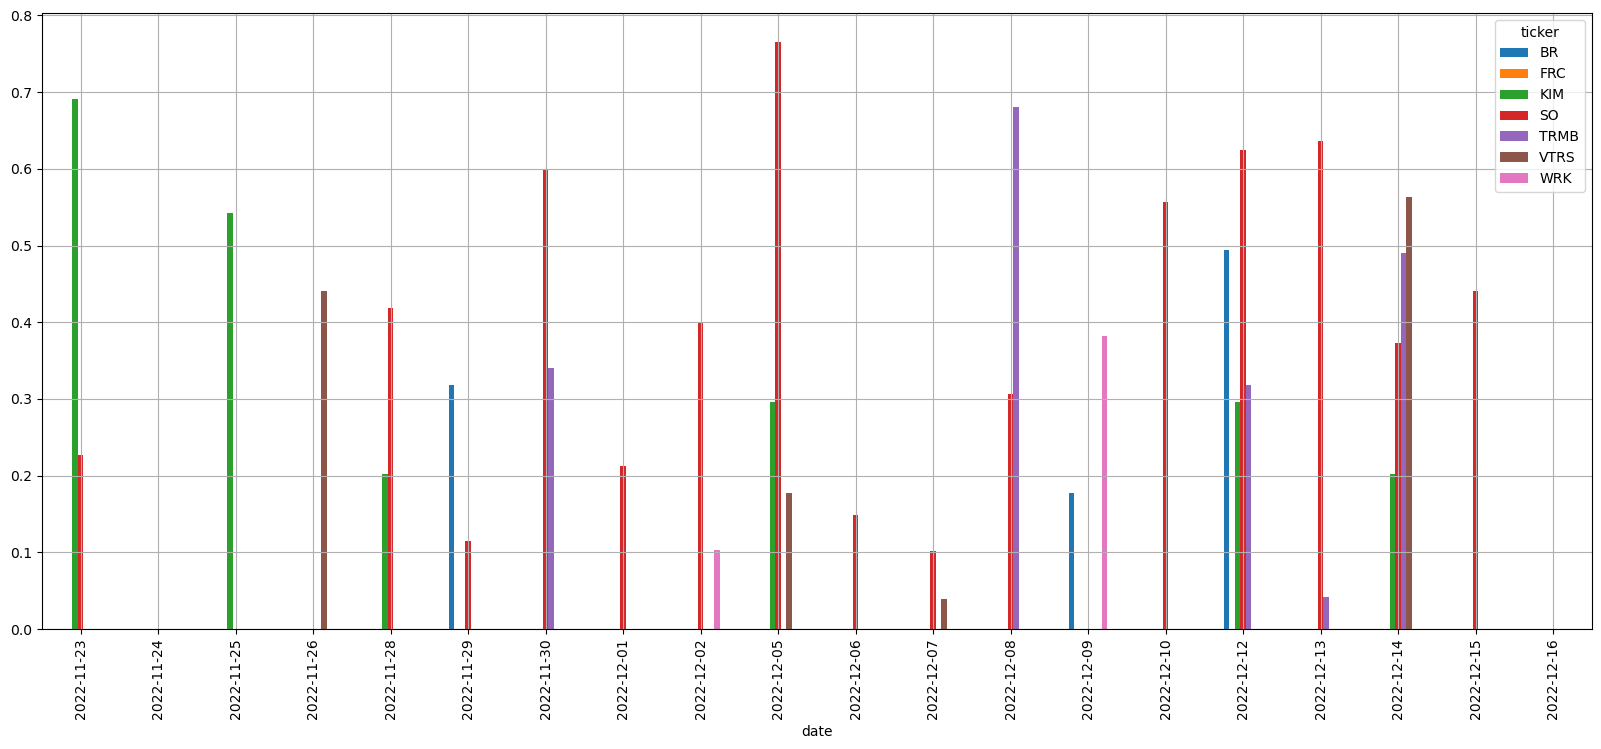

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
logger.info(f'TRADE_DATE|{datetime.today()}')
td_ameritrade.refresh_data()

full_portfolio_df = td_ameritrade.get_account_portfolio_data(masked_account_number)
logger.info('Full Portfolio:')
display(full_portfolio_df)

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
existing_stocks_to_trade = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
existing_stocks_to_trade = existing_stocks_to_trade[~existing_stocks_to_trade.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Existing Stocks to trade:')
display(existing_stocks_to_trade)

logger.info(f'Cash Equivilant:')
current_cash_balance = td_ameritrade.parse_accounts().loc[masked_account_number].currentBalances_cashBalance
cash_equivelants_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'CASH_EQUIVALENT')
display(cash_equivelants_df)
amount_for_trading = cash_equivelants_df.marketValue.sum() + existing_stocks_to_trade.marketValue.sum() + current_cash_balance
logger.info(f'Amount for trading: {amount_for_trading}')

investment_base = 1000
investment_amount = math.floor(amount_for_trading / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

stocks_to_trade = list(set(long_weights.index.to_list() + list(existing_stocks_to_trade.index.get_level_values('symbol'))))
quotes_for_stocks = td_ameritrade.get_quotes(stocks_to_trade)

display(quotes_for_stocks[['bidPrice', 'askPrice', 'regularMarketLastPrice']])

weights_for_trade = optimal_weights.loc[stocks_to_trade].copy()
weights_for_trade['optimalWeights'] = weights_for_trade['optimalWeights'].map(lambda x: 0 if x < 0.05 else x)
display(weights_for_trade)

weights_for_trade = pd.concat([weights_for_trade, quotes_for_stocks['regularMarketLastPrice']], axis=1)
display(weights_for_trade)

current_holdings = td_ameritrade.get_holdings(masked_account_number, symbols=stocks_to_trade)
current_holdings = current_holdings.droplevel('account')
display(current_holdings)

print(f'Current investment amount: {investment_amount}')
min_shares_accepted = 5
weights_for_trade['amount'] = (weights_for_trade['optimalWeights'] * investment_amount).round(0)
weights_for_trade['marketValue'] = current_holdings['marketValue']
weights_for_trade['buy/sell'] = (weights_for_trade['marketValue'] - weights_for_trade['amount']) * -1
weights_for_trade['existingShares'] = current_holdings['longQuantity'].astype(int)
weights_for_trade['deltaShares'] = (weights_for_trade['buy/sell'] / weights_for_trade['regularMarketLastPrice']).astype(int)
weights_for_trade['abs_delta_shares'] = weights_for_trade.deltaShares.abs()
weights_for_trade['deltaMarketValue'] = (weights_for_trade['deltaShares'] * weights_for_trade['regularMarketLastPrice'])
weights_for_trade['totalShares'] = (weights_for_trade['existingShares'] + weights_for_trade['deltaShares'])
weights_for_trade['totalMarketValue'] = (weights_for_trade['totalShares'] * weights_for_trade['regularMarketLastPrice'])
display(weights_for_trade)

print(f'Total Market Value: {weights_for_trade.totalMarketValue.sum()}')

for symbol, row in weights_for_trade.iterrows():
    if row.deltaShares > 0:
        instruction = 'BUY'
        quantity = row.deltaShares
    else:
        instruction = 'SELL'
        quantity = abs(row.deltaShares)
        
    if quantity >= min_shares_accepted:
        order = amc.create_limit_order(masked_account_number, symbol, 'EQUITY', quantity, instruction, 'NORMAL', 'DAY', round(row.regularMarketLastPrice, 2))
        print(order)
        td_ameritrade.place_order(order)

2022-12-16 10:32:58,239|IRAHoldingsAdjustement|INFO|TRADE_DATE|2022-12-16 10:32:58.239079
2022-12-16 10:32:58,712|IRAHoldingsAdjustement|INFO|Full Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.50822             0.0   
         FRC               0.0     117.51000             0.0   
         VTIP              0.0      52.14316             0.0   
         VTRS              0.0      10.80000             0.0   
         VGK               0.0      59.10313             0.0   
         FNCL              0.0      40.44691             0.0   
         FSTA              0.0      42.61006             0.0   
         TRMB              0.0      57.35000             0.0   
         SO                0.0      69.34964             0.0   
         SCHM              0.0      77.81466             0.0   
         VWO               0.0      50.42377             0.0   
         KIM               0.0      21.59961             0.0   
         MMDA1             0.0       1.00000             0.0   
         BR                0.0     143.60000             0.0   
         VBR               0.0     169.07886             0.0   
         FGPHF             0.0       0.12293             0.0   
         WKHS              0.0      12.43990             0.0   
         EEENF             0.0       0.04960             0.0   
         VOO               0.0     370.43264             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF              -19.558055                           -0.98   
         FRC                 5.940000                            0.15   
         VTIP               -4.678245                           -0.14   
         VTRS              -39.375000                           -1.57   
         VGK               -28.740000                           -1.42   
         FNCL              -10.579200                           -1.68   
         FSTA               -2.900160                           -1.26   
         TRMB              -74.250000                           -3.18   
         SO                -57.400000                           -1.46   
         SCHM              -19.783150                           -1.46   
         VWO                -0.384050                           -0.06   
         KIM               -56.700000                           -1.46   
         MMDA1               0.000000                            0.00   
         BR                -34.290000                           -0.94   
         VBR                -6.342700                           -1.28   
         FGPHF            -500.000000                           -6.67   
         WKHS               50.000000                            2.63   
         EEENF              -0.075000                           -4.41   
         VOO              -653.706210                           -1.25   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          61.873               61.873                   0.0   
         FRC           33.000               33.000                   0.0   
         VTIP          71.973               71.973                   0.0   
         VTRS         225.000              225.000                   0.0   
         VGK           35.925               35.925                   0.0   
         FNCL          13.224               13.224                   0.0   
         FSTA           5.088                5.088                   0.0   
         TRMB          45.000               45.000                   0.0   
         SO            56.000               56.000                   0.0   
         SCHM          20.395               20.395                   0.0   
         VWO           15.362               15.362                   0.0   
         KIM          180.000              180.000                   0.0   
         MMDA1       5871.090             5871.090                   0.0  

2022-12-16 10:32:58,769|IRAHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.50822             0.0   
         FRC               0.0     117.51000             0.0   
         VTIP              0.0      52.14316             0.0   
         VTRS              0.0      10.80000             0.0   
         VGK               0.0      59.10313             0.0   
         FNCL              0.0      40.44691             0.0   
         FSTA              0.0      42.61006             0.0   
         TRMB              0.0      57.35000             0.0   
         SO                0.0      69.34964             0.0   
         SCHM              0.0      77.81466             0.0   
         VWO               0.0      50.42377             0.0   
         KIM               0.0      21.59961             0.0   
         BR                0.0     143.60000             0.0   
         VBR               0.0     169.07886             0.0   
         FGPHF             0.0       0.12293             0.0   
         WKHS              0.0      12.43990             0.0   
         EEENF             0.0       0.04960             0.0   
         VOO               0.0     370.43264             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF              -19.558055                           -0.98   
         FRC                 5.940000                            0.15   
         VTIP               -4.678245                           -0.14   
         VTRS              -39.375000                           -1.57   
         VGK               -28.740000                           -1.42   
         FNCL              -10.579200                           -1.68   
         FSTA               -2.900160                           -1.26   
         TRMB              -74.250000                           -3.18   
         SO                -57.400000                           -1.46   
         SCHM              -19.783150                           -1.46   
         VWO                -0.384050                           -0.06   
         KIM               -56.700000                           -1.46   
         BR                -34.290000                           -0.94   
         VBR                -6.342700                           -1.28   
         FGPHF            -500.000000                           -6.67   
         WKHS               50.000000                            2.63   
         EEENF              -0.075000                           -4.41   
         VOO              -653.706210                           -1.25   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          61.873               61.873                   0.0   
         FRC           33.000               33.000                   0.0   
         VTIP          71.973               71.973                   0.0   
         VTRS         225.000              225.000                   0.0   
         VGK           35.925               35.925                   0.0   
         FNCL          13.224               13.224                   0.0   
         FSTA           5.088                5.088                   0.0   
         TRMB          45.000               45.000                   0.0   
         SO            56.000               56.000                   0.0   
         SCHM          20.395               20.395                   0.0   
         VWO           15.362               15.362                   0.0   
         KIM          180.000              180.000                   0.0   
         BR            27.000               27.000                   0.0   
         VBR            3.094                3.094                   0.0   
         FGPHF     100000.000           100000.000         

2022-12-16 10:32:59,025|IRAHoldingsAdjustement|INFO|Existing Stocks to trade:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 FRC               0.0     117.51000             0.0   
         VTRS              0.0      10.80000             0.0   
         TRMB              0.0      57.35000             0.0   
         SO                0.0      69.34964             0.0   
         KIM               0.0      21.59961             0.0   
         BR                0.0     143.60000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 FRC                    5.940                            0.15   
         VTRS                 -39.375                           -1.57   
         TRMB                 -74.250                           -3.18   
         SO                   -57.400                           -1.46   
         KIM                  -56.700                           -1.46   
         BR                   -34.290                           -0.94   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 FRC             33.0                 33.0                   0.0   
         VTRS           225.0                225.0                   0.0   
         TRMB            45.0                 45.0                   0.0   
         SO              56.0                 56.0                   0.0   
         KIM            180.0                180.0                   0.0   
         BR              27.0                 27.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---5311 FRC         3971.22                 3971.22   
         VTRS        2467.13                 2467.13   
         TRMB        2259.90                 2259.90   
         SO          3883.32                 3883.32   
         KIM         3818.70                 3818.70   
         BR          3609.63                 3609.63   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---5311 FRC                            33.0    EQUITY  33616C100           0   
         VTRS                          225.0    EQUITY  92556V106           0   
         TRMB                           45.0    EQUITY  896239100           0   
         SO                             56.0    EQUITY  842587107           0   
         KIM                           180.0    EQUITY  49446R109           0   
         BR                             27.0    EQUITY  11133T103           0   

                type  
account  symbol       
#---5311 FRC       0  
         VTRS      0  
         TRMB      0  
         SO        0  
         KIM       0  
         BR        0

2022-12-16 10:32:59,047|IRAHoldingsAdjustement|INFO|Cash Equivilant:


,,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,description,type
account,symbol,,,,,,,,,,,,,,,
#---5311,MMDA1,0.0,1.0,0.0,0.0,0.0,5871.09,5871.09,0.0,5871.09,0.0,5871.09,CASH_EQUIVALENT,9ZZZFD104,FDIC INSURED DEPOSIT ACCOUNT CORE NOT COVERE...,MONEY_MARKET_FUND


2022-12-16 10:32:59,076|IRAHoldingsAdjustement|INFO|Amount for trading: 25880.99
Amount to invest: 25000


,bidPrice,askPrice,regularMarketLastPrice
TRMB,50.20,50.24,50.210
VTRS,10.96,10.97,10.965
BR,133.48,133.78,133.690
WRK,35.11,35.12,35.120
FRC,120.26,120.40,120.340
SO,69.33,69.35,69.345
KIM,21.21,21.22,21.215


,optimalWeights
TRMB,0.10
VTRS,0.15
BR,0.15
WRK,0.15
FRC,0.15
SO,0.15
KIM,0.15


,optimalWeights,regularMarketLastPrice
TRMB,0.10,50.210
VTRS,0.15,10.965
BR,0.15,133.690
WRK,0.15,35.120
FRC,0.15,120.340
SO,0.15,69.345
KIM,0.15,21.215


,marketValue,longQuantity
symbol,,
BR,3609.63,27.0
FRC,3971.22,33.0
KIM,3818.70,180.0
SO,3883.32,56.0
TRMB,2259.90,45.0
VTRS,2467.13,225.0
WRK,0.00,0.0


Current investment amount: 25000


,optimalWeights,regularMarketLastPrice,amount,marketValue,buy/sell,existingShares,deltaShares,abs_delta_shares,deltaMarketValue,totalShares,totalMarketValue
TRMB,0.10,50.210,2500.0,2259.90,240.10,45,4,4,200.840,49,2460.290
VTRS,0.15,10.965,3750.0,2467.13,1282.87,225,116,116,1271.940,341,3739.065
BR,0.15,133.690,3750.0,3609.63,140.37,27,1,1,133.690,28,3743.320
WRK,0.15,35.120,3750.0,0.00,3750.00,0,106,106,3722.720,106,3722.720
FRC,0.15,120.340,3750.0,3971.22,-221.22,33,-1,1,-120.340,32,3850.880
SO,0.15,69.345,3750.0,3883.32,-133.32,56,-1,1,-69.345,55,3813.975
KIM,0.15,21.215,3750.0,3818.70,-68.70,180,-3,3,-63.645,177,3755.055


Total Market Value: 25085.304999999997
{'account': '#---5311', 'symbol': 'VTRS', 'asset_type': 'EQUITY', 'quantity': 116.0, 'instruction': 'BUY', 'session': 'NORMAL', 'duration': 'DAY', 'order_type': 'LIMIT', 'price': 10.96}
Placed LIMIT BUY order on #---5311 for 116.0 shares of VTRS at 10.96
{'account': '#---5311', 'symbol': 'WRK', 'asset_type': 'EQUITY', 'quantity': 106.0, 'instruction': 'BUY', 'session': 'NORMAL', 'duration': 'DAY', 'order_type': 'LIMIT', 'price': 35.12}
Placed LIMIT BUY order on #---5311 for 106.0 shares of WRK at 35.12
